## Synonyms evaluation

A methodology to evaluate a goodness-of-fit of word embeddings.

### Approach:

1. Categorize a dictionary of words into clusters of synonyms
2. Select a set of reasonably big clusters and
3. Evaluate how many unique bit representations there is for each synonym cluster
4. Evaluate how many, and how well are the best bits consistent for given synonym cluster

In [1]:
import pandas as pd
from nltk.corpus import wordnet as wn

vec_length = 38
epochs = 10

vecs_df = pd.read_csv("../vectors/1b%sd_vectors_e%s_nonbin" % (vec_length, epochs), 
                      skiprows=[0], header=None, sep=" ")
vecs_df = vecs_df.set_index(0)
vecs_df = vecs_df.drop(columns=[vecs_df.columns[-1]])
vecs_df = vecs_df.replace(vecs_df.values.max(), 1)
vecs_df = vecs_df.replace(vecs_df.values.min(), 0)
# retype to minimal range int to save space
vecs_df = vecs_df.astype('int8')
vecs_df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
0,,,,,,,,,,,,,,,,,,,,,
</s>,1,1,0,0,1,1,0,1,0,1,...,1,0,0,0,0,1,0,1,1,1
the,1,0,1,1,0,0,0,1,1,1,...,0,1,1,0,1,0,1,1,1,0
of,1,0,1,1,0,0,0,1,1,1,...,0,1,1,0,1,0,1,1,1,0
and,1,0,1,1,0,0,0,1,1,1,...,0,1,1,0,1,0,1,1,1,0
one,1,0,1,1,0,0,1,1,1,0,...,0,0,1,0,1,0,1,1,1,0
in,1,0,1,1,0,0,0,1,1,1,...,0,1,1,0,1,0,1,1,1,0
a,1,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,0,0
to,0,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,1,0
zero,1,0,1,1,0,0,1,1,1,0,...,0,0,1,0,1,0,1,1,1,0


In [2]:
# inference of synonyms for root lemma
for ss in wn.synsets('see'):
    print(ss.name(), ss.lemma_names())

see.n.01 ['see']
see.v.01 ['see']
understand.v.02 ['understand', 'realize', 'realise', 'see']
witness.v.02 ['witness', 'find', 'see']
visualize.v.01 ['visualize', 'visualise', 'envision', 'project', 'fancy', 'see', 'figure', 'picture', 'image']
see.v.05 ['see', 'consider', 'reckon', 'view', 'regard']
learn.v.02 ['learn', 'hear', 'get_word', 'get_wind', 'pick_up', 'find_out', 'get_a_line', 'discover', 'see']
watch.v.03 ['watch', 'view', 'see', 'catch', 'take_in']
meet.v.01 ['meet', 'run_into', 'encounter', 'run_across', 'come_across', 'see']
determine.v.08 ['determine', 'check', 'find_out', 'see', 'ascertain', 'watch', 'learn']
see.v.10 ['see', 'check', 'insure', 'see_to_it', 'ensure', 'control', 'ascertain', 'assure']
see.v.11 ['see']
see.v.12 ['see']
visit.v.01 ['visit', 'see']
attend.v.02 ['attend', 'take_care', 'look', 'see']
see.v.15 ['see']
go_steady.v.01 ['go_steady', 'go_out', 'date', 'see']
see.v.17 ['see']
see.v.18 ['see']
see.v.19 ['see']
examine.v.02 ['examine', 'see']
exper

In [3]:
# interval counts for plotting
%matplotlib inline
import matplotlib.pyplot as plt


def series_to_intvl_counts(s, bins=60, bin_range=None):
    if bin_range is None and bins is not None:
        no_bins = bins
        step = int((s.max() - s.min()) / (no_bins+1))
        step = 1 if step == 0 else step
        bin_range = range(s.min()-10, s.max()+10 + int(s.max() / no_bins), step)
    pd.cut(s.values, bins=bin_range)
    return pd.Series(pd.cut(s.values, bins=bin_range, include_lowest=True)).value_counts(sort=False)

In [4]:
# 1. one category is a word with synonyms in dictionary
from nltk.corpus import wordnet as wn

def syns_for_lemma(lemma):
    syn_lemmas = set()
    for ss in wn.synsets(lemma):
        new_syn_lemmas = set(ss.lemma_names())
        syn_lemmas |= new_syn_lemmas
    return syn_lemmas

In [5]:
def vecs_for_lemmaset(syn_lemmas_seen, vecs_df):
    return vecs_df.loc[syn_lemmas_seen]

In [6]:
def vecs_for_synset(lemma, vecs_df):
    syn_lemmas = syns_for_lemma(lemma)
    syn_lemmas_seen = set(filter(lambda syn: syn in vecs_df.index, syn_lemmas))
    return vecs_for_lemmaset(syn_lemmas_seen, vecs_df)

In [7]:
#2: select reasonably big clusters
def top_lemmas_by_synset(vecs_df, q=0.99):
    lemmas_syns = [syns_for_lemma(str(lemma)) for lemma in vecs_df.index]
    lemmas_syns_seen = [filter(lambda syn: syn in vecs_df.index, syns) for syns in lemmas_syns]
    seen_lemmas_count = list(map(lambda syns: len(set(syns)), lemmas_syns_seen))
    counts_s = pd.Series(seen_lemmas_count, index=vecs_df.index)
    return counts_s[counts_s >= counts_s.quantile(q)]

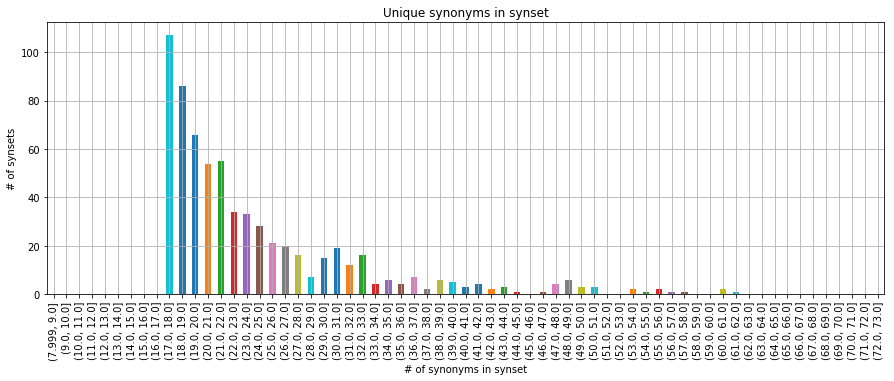

In [8]:
title = "Unique synonyms in synset"

plt.xlabel('# of synonyms in synset')
plt.ylabel('# of synsets')

all_lemmas_synset_count = top_lemmas_by_synset(vecs_df)
series_to_intvl_counts(all_lemmas_synset_count, bins=25).plot("bar", figsize=(15, 5), grid=True, title=title)

In [9]:
top_lemmas_count = top_lemmas_by_synset(vecs_df)
top_lemmas_count.describe()

count    663.000000
mean      24.749623
std        8.166548
min       18.000000
25%       19.000000
50%       22.000000
75%       27.000000
max       62.000000
dtype: float64

In [10]:
top_lemmas_count.index[0]

'have'

In [11]:
# retrieve vectors for given cluster
vecs_for_synset(top_lemmas_count.index[0], vecs_df)

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
0,,,,,,,,,,,,,,,,,,,,,
induce,0,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,0,0
take,0,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,1,0
possess,0,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,1,0
make,0,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,1,0
sustain,0,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,1,0
birth,1,0,1,1,0,0,0,1,1,1,...,0,0,1,0,1,0,1,1,1,0
receive,0,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,1,0
let,1,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,1,0
feature,1,0,1,1,0,0,0,1,1,1,...,0,1,1,1,1,0,1,1,0,0


In [12]:
# 3: compute fit score for category
def unique_vecs_for_syns(root_lemma, vecs_df):
    group_vecs = vecs_for_synset(root_lemma, vecs_df)
    return len(group_vecs.drop_duplicates())

## Number of unique vectors in one synset

In [13]:
syns_vector_groups = pd.Series(top_lemmas_count.index, index=top_lemmas_count.index) \
                        .apply(lambda root_lemma: unique_vecs_for_syns(root_lemma, vecs_df))
syns_vector_groups.describe()

count    663.000000
mean      19.295626
std        5.462874
min        7.000000
25%       16.000000
50%       19.000000
75%       22.000000
max       42.000000
Name: 0, dtype: float64

### Aggregared # of unique vector types in synset

In [14]:
syns_vector_groups.describe()

count    663.000000
mean      19.295626
std        5.462874
min        7.000000
25%       16.000000
50%       19.000000
75%       22.000000
max       42.000000
Name: 0, dtype: float64

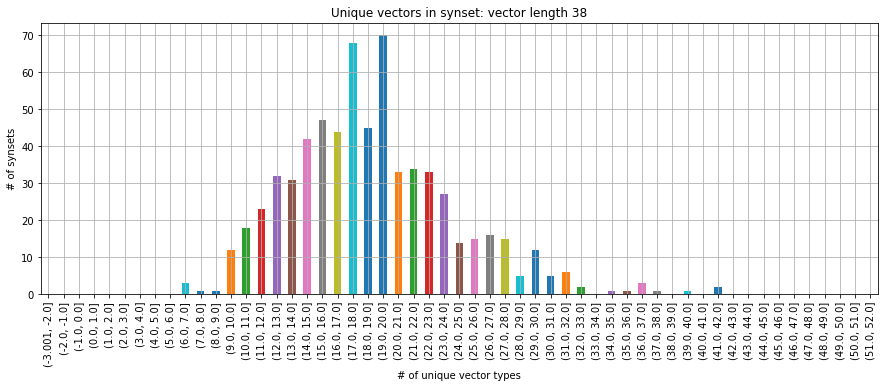

In [29]:
title = "Unique vectors in synset: vector length %s" % vec_length

plt.xlabel('# of unique vector types')
plt.ylabel('# of synsets')

series_to_intvl_counts(syns_vector_groups, bins=25).plot("bar", figsize=(15, 5), grid=True, title=title)

In [16]:
import itertools
import numpy as np


def get_zero_one_combinations(l):
    if l < 10:
        i_ones_combs = [[np.bincount(xs, minlength=l) for xs in itertools.combinations(range(l),  i+1)] 
                        for i in range(l)]
        i_ones_merged = itertools.chain.from_iterable(i_ones_combs)
        return np.array(list(i_ones_merged)).astype('int8')
    else:
        # generates random sample of 2^20 zero-one vectors, if the size is too big
        return np.random.choice([0, 1], size=(2**10, l)).astype('int8')

## Number of occurrences of each vector type in dictionary 

In [17]:
%%time
# all words might have the same vector representation to reach 1
# we need to see the variability of vectors - here through sizes of groups by type

# TODO: choose a method for candidate selection - better to use seen vectors for larger lengths, 
# and all combinations for shorter vec lengths

# count_candidates = get_zero_one_combinations(v_len)
count_candidates = vecs_df.drop_duplicates().values

# selection of a random sample, as counts for all take too long to aggregate
count_candidates = count_candidates[np.random.randint(len(count_candidates), size=1024)]

vec_type_lens = [sum(np.all(vecs_df.values == v, axis=1)) for v in count_candidates]
vec_type_lens_s = pd.Series(vec_type_lens, index=map(str, count_candidates))
vec_type_lens_s.values

CPU times: user 2min 20s, sys: 53.2 ms, total: 2min 20s
Wall time: 2min 20s


In [18]:
count_candidates

array([[0, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [19]:
sum(np.all(vecs_df.values == count_candidates[558], axis=1))

1

In [20]:
vec_type_lens_s.describe()

count    1024.000000
mean        1.301758
std         2.720214
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        61.000000
dtype: float64

### Number of times that each vector type has occured

In [21]:
bin_range = list(range(0, 40)) + [len(vecs_df)]
intvl_counts = series_to_intvl_counts(vec_type_lens_s, bin_range=bin_range)
intvl_counts

(-0.001, 1.0]      979
(1.0, 2.0]          20
(2.0, 3.0]           3
(3.0, 4.0]           1
(4.0, 5.0]           3
(5.0, 6.0]           4
(6.0, 7.0]           1
(7.0, 8.0]           1
(8.0, 9.0]           1
(9.0, 10.0]          1
(10.0, 11.0]         3
(11.0, 12.0]         0
(12.0, 13.0]         0
(13.0, 14.0]         2
(14.0, 15.0]         1
(15.0, 16.0]         0
(16.0, 17.0]         0
(17.0, 18.0]         0
(18.0, 19.0]         0
(19.0, 20.0]         0
(20.0, 21.0]         1
(21.0, 22.0]         0
(22.0, 23.0]         0
(23.0, 24.0]         0
(24.0, 25.0]         0
(25.0, 26.0]         0
(26.0, 27.0]         0
(27.0, 28.0]         1
(28.0, 29.0]         0
(29.0, 30.0]         0
(30.0, 31.0]         0
(31.0, 32.0]         0
(32.0, 33.0]         0
(33.0, 34.0]         0
(34.0, 35.0]         0
(35.0, 36.0]         0
(36.0, 37.0]         0
(37.0, 38.0]         0
(38.0, 39.0]         0
(39.0, 60238.0]      2
dtype: int64

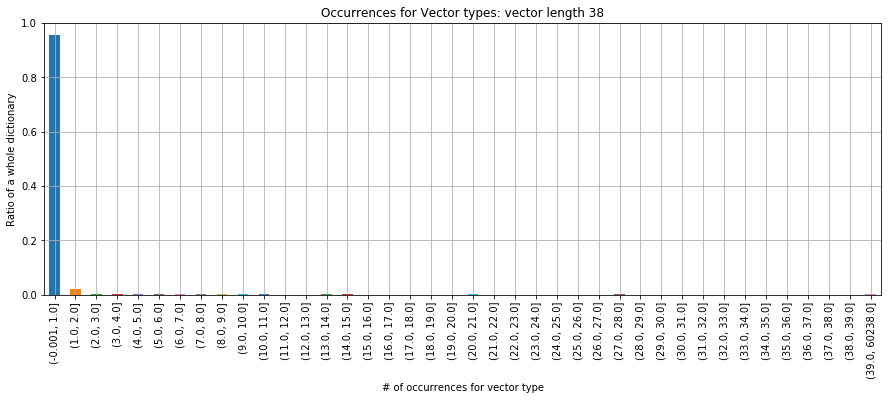

In [22]:
title = "Occurrences for Vector types: vector length %s" % vec_length

plt.xlabel('# of occurrences for vector type')
plt.ylabel('Ratio of a whole dictionary')

intvl_counts_norm = intvl_counts / sum(intvl_counts)
intvl_counts_norm.plot("bar", figsize=(15, 5), grid=True, ylim=(0, 1), title=title)

In [23]:
# 4: plot 4.1 evolution of unique vectors for synset + 4.2 std (or confidence intervals) of vector types

In [24]:
# load the vectors trained in selected interval length, with selected step
len_range = range(4, 138, 2)
epochs = 10

output_pattern = ["vectors/1b%sd_vectors_e%s_nonbin" % (l, epochs) for l in len_range]
output_pattern

['vectors/1b4d_vectors_e10_nonbin',
 'vectors/1b6d_vectors_e10_nonbin',
 'vectors/1b8d_vectors_e10_nonbin',
 'vectors/1b10d_vectors_e10_nonbin',
 'vectors/1b12d_vectors_e10_nonbin',
 'vectors/1b14d_vectors_e10_nonbin',
 'vectors/1b16d_vectors_e10_nonbin',
 'vectors/1b18d_vectors_e10_nonbin',
 'vectors/1b20d_vectors_e10_nonbin',
 'vectors/1b22d_vectors_e10_nonbin',
 'vectors/1b24d_vectors_e10_nonbin',
 'vectors/1b26d_vectors_e10_nonbin',
 'vectors/1b28d_vectors_e10_nonbin',
 'vectors/1b30d_vectors_e10_nonbin',
 'vectors/1b32d_vectors_e10_nonbin',
 'vectors/1b34d_vectors_e10_nonbin',
 'vectors/1b36d_vectors_e10_nonbin',
 'vectors/1b38d_vectors_e10_nonbin',
 'vectors/1b40d_vectors_e10_nonbin',
 'vectors/1b42d_vectors_e10_nonbin',
 'vectors/1b44d_vectors_e10_nonbin',
 'vectors/1b46d_vectors_e10_nonbin',
 'vectors/1b48d_vectors_e10_nonbin',
 'vectors/1b50d_vectors_e10_nonbin',
 'vectors/1b52d_vectors_e10_nonbin',
 'vectors/1b54d_vectors_e10_nonbin',
 'vectors/1b56d_vectors_e10_nonbin',
 've

In [25]:
# 4.1
# def 